# Определение перспективного тарифа для телеком-компании

## Цели исследования
В нашем распоряжении  выборки данных по длительности звонков, количеству смс, объему использованного траффика случайных клиентов телеком-компании за 2018 год. 
Данные представлены в разрезе двух тарифов - "smart" и "ultra". 
Необходимо на основании представленных данных выбрать более перспективный для маркетинговых вложений тариф. 

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib as plt
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')
messages = pd.read_csv('/datasets/messages.csv')

# Предобработка данных

#### Предобратка данных в таблице calls

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Видно, что в таблице нет пропущенных значений. Необходимо перевести колонку `call_date` в формат datetime, а также дополнительно изучить данные в колонке `duration`

Также, для дальнейших расчетов, округлим минуты в колонке `duration` до ближайшего положительного числа, затем переведем тип колонки в int

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls['month'] = calls['call_date'].dt.month
calls['duration'] = calls['duration'].apply(math.ceil) 
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

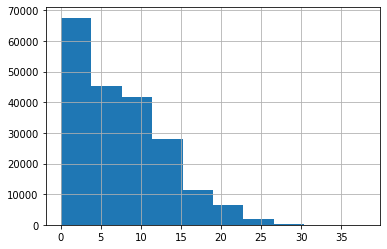

In [5]:
calls['duration'].hist()
calls['duration'].describe()

Значения в колнке `duration` не вызывают вопросов. Максимальная длительность звонка - 38 минут, минимальная длительность звонка - 0 минут - данные звонки соответвуют пропущенным.

#### Предобработка данных в таблице internet

In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Исходя из данных метода info можем увидеть: 
1. Наличие колонки unnamed - изучим ее подробнее 
2. Необходимо привести значения в колонке `session_date` к типу datetime
3. Исследовать дополнительно значения в колонке `mb_used`. (Округлять значения на данном этапе нет необходимости, так как по правилам оператора округление производится по всем сессиям юзера суммарно за месяц. 

In [7]:
internet.tail()

,Unnamed: 0,id,mb_used,session_date,user_id
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


Колонкка `Unnamed: 0` соответствует индексу таблицы. Удалим данную колонку

In [8]:
internet = internet.drop(columns = 'Unnamed: 0')
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [9]:
internet['session_date'] = pd.to_datetime(internet['session_date'],format = '%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
 4   month         149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


19598


count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

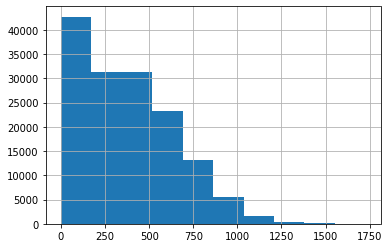

In [10]:
internet['mb_used'].hist()
print (len(internet[internet['mb_used'] == 0]))
internet['mb_used'].describe()

Из данных таблицы видно, что существуют сессии с нулевым количеством использования мб интернета, таких записей приблизительно 13 % от общего количества. Возможно, это случай, когда включена передача данных на мобильном устройстве, при условии, что нет фоновых приложений, потребляющих траффик. Учитывая, что такие сессии не изменят размер выручки при расчете итоговой выручки по тарифу, а также то, что мы не анализируем общее количество сессий подключения, удалим строки с нулевыми значениями для облегчения датафрейма.

In [11]:
internet = internet.query('mb_used!=0')
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            129798 non-null  object        
 1   mb_used       129798 non-null  float64       
 2   session_date  129798 non-null  datetime64[ns]
 3   user_id       129798 non-null  int64         
 4   month         129798 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.9+ MB


#### Предобработка данных в таблице tariffs

In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [13]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В описаниях тарифов указано количество включенных мб в пакет, а расчет стоимости тарифа ведется на основании гб. Необходимо перевести значения в колонке `mb_per_month_included` в гб (в 1 гб 1024 мб), а также переименуем саму колонку в `gb_per_month_included`

In [14]:
tariffs['mb_per_month_included'] = (tariffs['mb_per_month_included']/1024).astype('int')
tariffs = tariffs.rename(columns = {'mb_per_month_included':'gb_per_month_included'})

In [15]:
tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


#### Предобработка данных в таблице users

In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Видно, что в таблице представлены данные по 500 клиентам компании. 
Доработаем данные в таблице: 
1. Значения в колонке `churn_date` приведем к типу datetime, также, создадим колонку `is_active` с типом bool (1, если пакет еще активен, 0, если нет) 
2. Значения в колонке `reg_date` приведем к типу datetime
3. Изучим дополнительно значения в колонках `user_id`, `age`, `city`, `tariff`, а также дедуплицируем имеющиеся данные. 

In [17]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d', errors = 'coerce')
users['is_active'] = users['churn_date'].isnull()

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    object        
 7   tariff      500 non-null    object        
 8   is_active   500 non-null    bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 31.9+ KB


In [18]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

In [19]:
users['user_id'].value_counts()

1024    1
1353    1
1366    1
1365    1
1364    1
       ..
1185    1
1184    1
1183    1
1182    1
1023    1
Name: user_id, Length: 500, dtype: int64

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

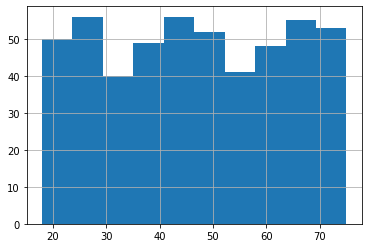

In [20]:
users['age'].hist()
users['age'].describe()

Отличная выборка! Представлены в равной мере все возрастные группы! 

In [21]:
users['city'].value_counts()

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Архангельск         1
Химки               1
Нижневартовск       1
Иваново             1
Подольск            1
Name: city, Length: 76, dtype: int64

In [22]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [23]:
users.duplicated().sum()

0

Дублей нет, данные выглядят корректными.

#### Предобработка данных в таблице messages

In [24]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [25]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Приведем данные в колонке `mesage_date` к типу datetime 

In [26]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


### Расчет выручки по месяцам

В таблицах `messages`, `calls`, `internet` найдем объем потраченных сообщений, минут, гб по каждому юзеру в разрезе каждого месяца. 

In [27]:
messages_pivot=messages.pivot_table(index = ['user_id', 'month'], values ='id', aggfunc ='count').reset_index()
messages_pivot = messages_pivot.rename(columns = {'id':'messages'})
messages_pivot

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [28]:
calls_pivot = calls.pivot_table(index =['user_id', 'month'], values = 'duration', aggfunc = 'sum').reset_index()
calls_pivot

,user_id,month,duration
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466
...,...,...,...
3169,1498,10,247
3170,1499,9,70
3171,1499,10,449
3172,1499,11,612


In [29]:
internet_pivot = internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum').reset_index()
internet_pivot['gb_used'] = (internet_pivot['mb_used']/1024).apply(math.ceil)
internet_pivot

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3
1,1000,6,23233.77,23
2,1000,7,14003.64,14
3,1000,8,14055.93,14
4,1000,9,14568.91,15
...,...,...,...,...
3196,1498,10,20579.36,21
3197,1499,9,1845.75,2
3198,1499,10,17788.51,18
3199,1499,11,17963.31,18


In [30]:
tariffs = tariffs.rename(columns = {'tariff_name':'tariff'})

Объединим полученные данные в одну таблицу, а также добавим данные по количеству доступных минут, смс и гб из таблицы с тарифами

In [31]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,is_active
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,True
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,True
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,True
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,True
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,True
...,...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,True
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,True
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,True
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,False


Создадим пустой фрейм с уникальными id клиентов и месяцами для дальнейшего мерджа с таблицами

In [32]:
user_id = users.user_id.unique()
month = [1,2,3,4,5,6,7,8,9,10,11,12]

index = pd.MultiIndex.from_product([user_id, month], names = ["user_id", "month"])

general_users = pd.DataFrame(index = index).reset_index()
general_users

,user_id,month
0,1000,1
1,1000,2
2,1000,3
3,1000,4
4,1000,5
...,...,...
5995,1499,8
5996,1499,9
5997,1499,10
5998,1499,11


In [33]:
general_users = (general_users
                 .merge(users[['user_id', 'city', 'tariff', 'is_active']], on = 'user_id', how = 'left')
                 .merge(calls_pivot, on = ['user_id', 'month'], how = 'left')
                 .merge(messages_pivot, on = ['user_id', 'month'], how = 'left')
                 .merge(internet_pivot, on = ['user_id', 'month'], how = 'left')
                 .merge(tariffs, on = 'tariff')
)
general_users = general_users.drop(columns = 'mb_used')
general_users

,user_id,month,city,tariff,is_active,duration,messages,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,1,Краснодар,ultra,True,NaN,NaN,NaN,1000,30,3000,1950,150,1,1
1,1000,2,Краснодар,ultra,True,NaN,NaN,NaN,1000,30,3000,1950,150,1,1
2,1000,3,Краснодар,ultra,True,NaN,NaN,NaN,1000,30,3000,1950,150,1,1
3,1000,4,Краснодар,ultra,True,NaN,NaN,NaN,1000,30,3000,1950,150,1,1
4,1000,5,Краснодар,ultra,True,159.0,22.0,3.0,1000,30,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1499,8,Пермь,smart,True,NaN,NaN,NaN,50,15,500,550,200,3,3
5996,1499,9,Пермь,smart,True,70.0,11.0,2.0,50,15,500,550,200,3,3
5997,1499,10,Пермь,smart,True,449.0,48.0,18.0,50,15,500,550,200,3,3
5998,1499,11,Пермь,smart,True,612.0,59.0,18.0,50,15,500,550,200,3,3


In [34]:
general_users.user_id.unique().shape

(500,)

Для того, чтобы не учитывать абонентскую плату по месяцам, в которых пользователи не пользовались пакетом (такие месяца полчились из-за способа сбора данных), удалим такие месяца из датафрейма

In [35]:
index = (general_users[(general_users['duration'].isna()==True)
                       &(general_users['gb_used'].isna()==True)
                       &(general_users['messages'].isna()==True)].index
)
general_users = general_users.drop(index = index).reset_index()
general_users

,index,user_id,month,city,tariff,is_active,duration,messages,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,4,1000,5,Краснодар,ultra,True,159.0,22.0,3.0,1000,30,3000,1950,150,1,1
1,5,1000,6,Краснодар,ultra,True,172.0,60.0,23.0,1000,30,3000,1950,150,1,1
2,6,1000,7,Краснодар,ultra,True,340.0,75.0,14.0,1000,30,3000,1950,150,1,1
3,7,1000,8,Краснодар,ultra,True,408.0,81.0,14.0,1000,30,3000,1950,150,1,1
4,8,1000,9,Краснодар,ultra,True,466.0,57.0,15.0,1000,30,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,5985,1498,10,Владикавказ,smart,False,247.0,42.0,21.0,50,15,500,550,200,3,3
3210,5996,1499,9,Пермь,smart,True,70.0,11.0,2.0,50,15,500,550,200,3,3
3211,5997,1499,10,Пермь,smart,True,449.0,48.0,18.0,50,15,500,550,200,3,3
3212,5998,1499,11,Пермь,smart,True,612.0,59.0,18.0,50,15,500,550,200,3,3


Выполним проверку, что удаленные юзеры не совершили ни одного звонка, не отпривили ни одного смс, не использовали ни одного гб интернета.

In [36]:
bad_users = []
for user in users.user_id.unique():
    if user not in general_users.user_id.unique():
        bad_users.append(user)
bad_users

display(messages_pivot.query('user_id in @bad_users'))
display(internet_pivot.query('user_id in @bad_users'))
display(calls_pivot.query('user_id in @bad_users'))

,user_id,month,messages


,user_id,month,mb_used,gb_used


,user_id,month,duration


In [37]:
general_users[general_users['month'].isna()==True]

,index,user_id,month,city,tariff,is_active,duration,messages,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute


In [38]:
general_users['month'] = general_users['month'].fillna(0)
general_users['duration'] = general_users['duration'].fillna(0)
general_users['gb_used'] = general_users['gb_used'].fillna(0)
general_users['messages'] = general_users['messages'].fillna(0)

print (general_users['duration'].isna().sum())
print (general_users['gb_used'].isna().sum())
print (general_users['messages'].isna().sum())

0
0
0


In [39]:
# Комментарий ревьюера
general_users.user_id.unique().shape 

(498,)

In [40]:
bad_users = []
for user in users.user_id.unique():
    if user not in general_users.user_id.unique():
        bad_users.append(user)
bad_users      # [1091, 1106, 1128, 1231, 1328, 1371, 1473, 1489]   

[1128, 1371]

In [41]:
general_users.query('user_id == 1371')

,index,user_id,month,city,tariff,is_active,duration,messages,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute


Найдем количество минут, смс и гб сверх пакета для каждой строки таблицы, как разницу фактически потраченных и включенных по тем строкам, где фактически потраченные превышают включенные

In [42]:
general_users['over_minutes'] = (
    (general_users['duration']-general_users['minutes_included'])
                                 .where(general_users['duration']>general_users['minutes_included'], 0)
)

general_users['over_gb'] = (
    (general_users['gb_used']-general_users['gb_per_month_included'])
                                 .where(general_users['gb_used']>general_users['gb_per_month_included'], 0)
)

general_users['over_messages'] = (
    (general_users['messages']-general_users['messages_included'])
                                 .where(general_users['messages']>general_users['messages_included'], 0)
)
general_users.head()

,index,user_id,month,city,tariff,is_active,duration,messages,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_minutes,over_gb,over_messages
0,4,1000,5,Краснодар,ultra,True,159.0,22.0,3.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0
1,5,1000,6,Краснодар,ultra,True,172.0,60.0,23.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0
2,6,1000,7,Краснодар,ultra,True,340.0,75.0,14.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0
3,7,1000,8,Краснодар,ultra,True,408.0,81.0,14.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0
4,8,1000,9,Краснодар,ultra,True,466.0,57.0,15.0,1000,30,3000,1950,150,1,1,0.0,0.0,0.0


Найдем итоговую выручку компании за месяц, как сумму базовой стоимости пакета + сумма произведений количества гб, смс и минут на стоимость гб, смс и минуты пакета соответственно.

In [43]:
general_users['total_sum'] = (
    general_users['rub_monthly_fee'] #базовая стоимость пакета
    + general_users['rub_per_minute'] * general_users['over_minutes'] #доп минуты
    + general_users['rub_per_message'] * general_users['over_messages'] #доп смс
    + general_users['rub_per_gb'] * general_users['over_gb'] #доп гб
)
general_users['total_sum'].head

<bound method NDFrame.head of 0       1950.0
1       1950.0
2       1950.0
3       1950.0
4       1950.0
         ...  
3209    1750.0
3210     550.0
3211    1150.0
3212    1513.0
3213     598.0
Name: total_sum, Length: 3214, dtype: float64>

### Ограничения: 
1. Не учтена дата начала пользования пакетом.
2. Не учтена дата окончания пользования пакетом. 
3. Не учтены исторические изменения в тарифах

## Изучение поведения пользователей в зависимости от  выбранного тарифа

Создадим отдельные таблицы с пользователями тарифа smart и ultra для удобства анализа

In [44]:
general_smart = general_users.query('tariff == "smart"')
general_ultra = general_users.query('tariff == "ultra"')

### Изучим пользовательский опыт клиентов с тарифом "Smart"

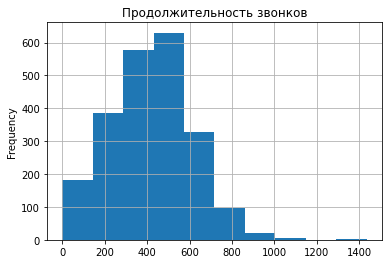

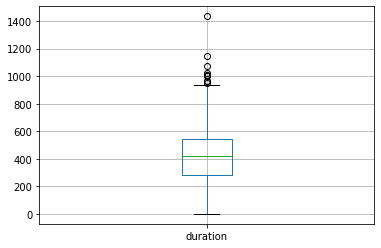

36203.06665209469


count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: duration, dtype: float64

In [45]:
general_smart['duration'].plot(kind = 'hist',grid = True, title ='Продолжительность звонков')
plt.pyplot.show()
general_smart.boxplot(column = 'duration')
plt.pyplot.show()
print (np.var(general_smart['duration']))
general_smart['duration'].describe()

Данные скошены влево, медиана = 427 минут, средняя продолжительность звонков = 421 минуту, стандартное отклонение = 187,5 минут. Единичные данные находятся за пределами номального распределения. 

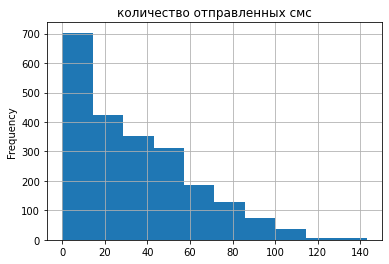

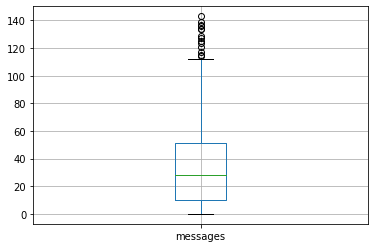

796.455482917076


count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

In [46]:
general_smart['messages'].plot(kind = 'hist',grid = True, title = 'количество отправленных смс')
plt.pyplot.show()
general_smart.boxplot(column = 'messages')
plt.pyplot.show()
print (np.var(general_smart['messages']))
general_smart['messages'].describe()

Большинство пользователей укладываются в ограничение по количеству смс.
Медиана = 34 смс, стандартное отклоненеие = 26. 
Значительное количетво измерений находится вне нормального распределения. 

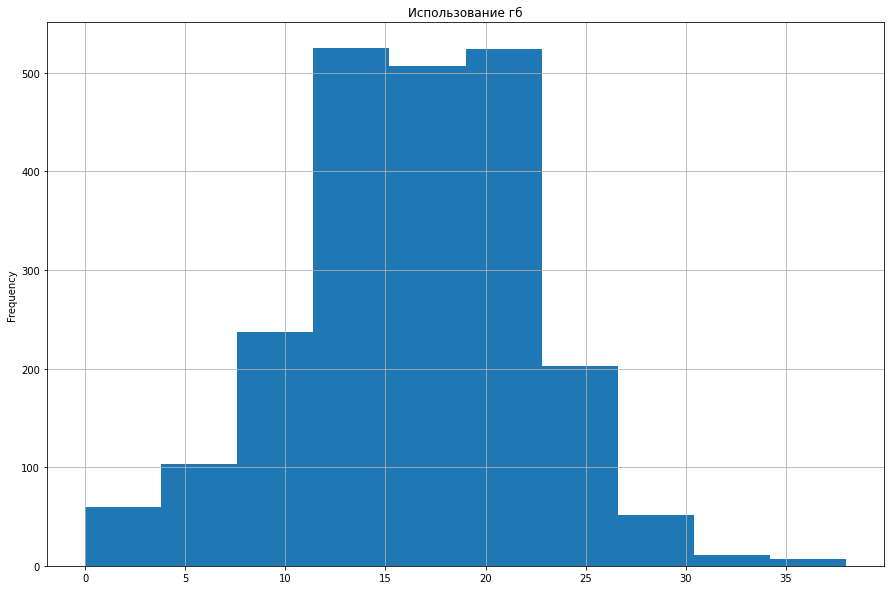

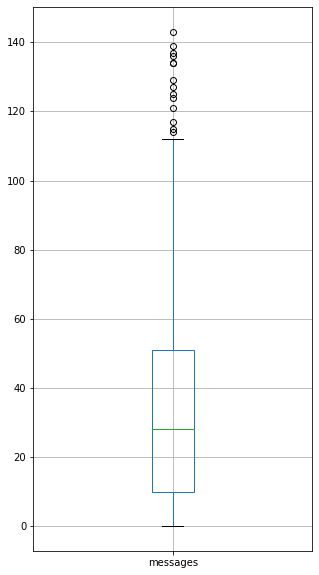

33.013887454837445


count    2229.000000
mean       16.328847
std         5.747061
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used, dtype: float64

In [47]:
general_smart['gb_used'].plot(kind = 'hist', figsize = (15,10),grid = True, title = 'Использование гб')
plt.pyplot.show()
general_smart.boxplot(column = 'messages', figsize = (5,10))
plt.pyplot.show()
print (np.var(general_smart['gb_used']))
general_smart['gb_used'].describe()

Найдем доли пользователей, не уложившихся в тарифные лимиты

In [48]:
print (sum(general_smart['over_minutes']>0)/len(general_smart))
print (sum(general_smart['over_messages']>0)/len(general_smart))
print (sum(general_smart['over_gb']>0)/len(general_smart))

0.3382682817406909
0.253028263795424
0.5850157021085689


Найдем среднюю выручку и размер переплаты

In [49]:
smart_max_boarder = (general_smart['total_sum'].mean() + np.std(general_smart['total_sum'])*3)
sum(general_smart['total_sum']>smart_max_boarder)

27

27 случаев, когда итоговая сумма заплаченная за месяц превышает три стандартных отклонения. Исключим эти данные из таблицы для дальнейшего анализа. 

In [50]:
#general_smart = general_smart.query('total_sum<@smart_max_boarder')

#### Выводы о пользовтельском опыте клиентов тарифа "smart"
1. 33 % пользователей не укладываются в лимит по минутам. 29% пользователей не укладываются в лимит по смс. 58% пользователей не укладываются в лимит по гб пакета. 
2. Медианное значение суммы пользования тарифом smart составляет 1012 рублей, средняя сумма, которую платят пользователи составляет 1291 рубль. 

### Изучим пользовательский опыт клиентов с тарифом "Ultra"

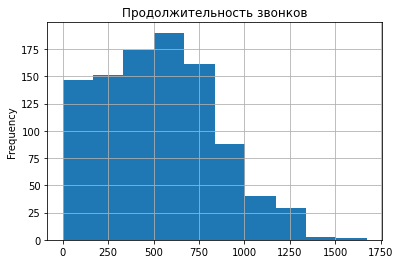

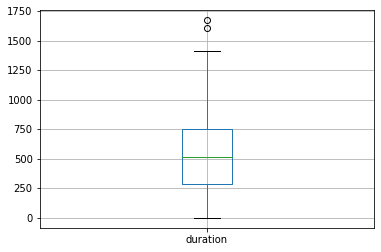

100771.2236172022


count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: duration, dtype: float64

In [51]:
general_ultra['duration'].plot(kind = 'hist',grid = True, title ='Продолжительность звонков')
plt.pyplot.show()
general_ultra.boxplot(column = 'duration')
plt.pyplot.show()
print (np.var(general_ultra['duration']))
general_ultra['duration'].describe()


На графиках видно только три случая, когда пользователь превысил лимит минут по тарифу. 
В среднем пользователи используют 557 минут звонков. 
Медианное значение составляет 538 минут, стандартное отклонение 311 минут. 

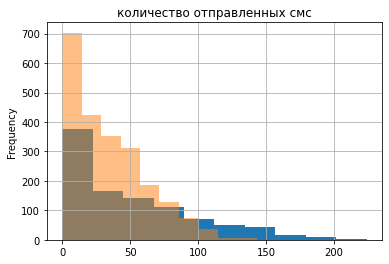

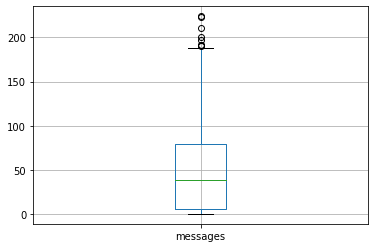

2282.9460753948824


count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

In [52]:
general_ultra['messages'].plot(kind = 'hist',grid = True, title = 'количество отправленных смс')
general_smart['messages'].plot(kind = 'hist',grid = True, title = 'количество отправленных смс', alpha = 0.5)
plt.pyplot.show()
general_ultra.boxplot(column = 'messages')
plt.pyplot.show()
print (np.var(general_ultra['messages']))
general_ultra['messages'].describe()

Ни один из пользователей тарифа ultra не израсходовал лимит смс. 
Максимальное значение составляет 224 смс сообщения, среднее 61 сообщение.

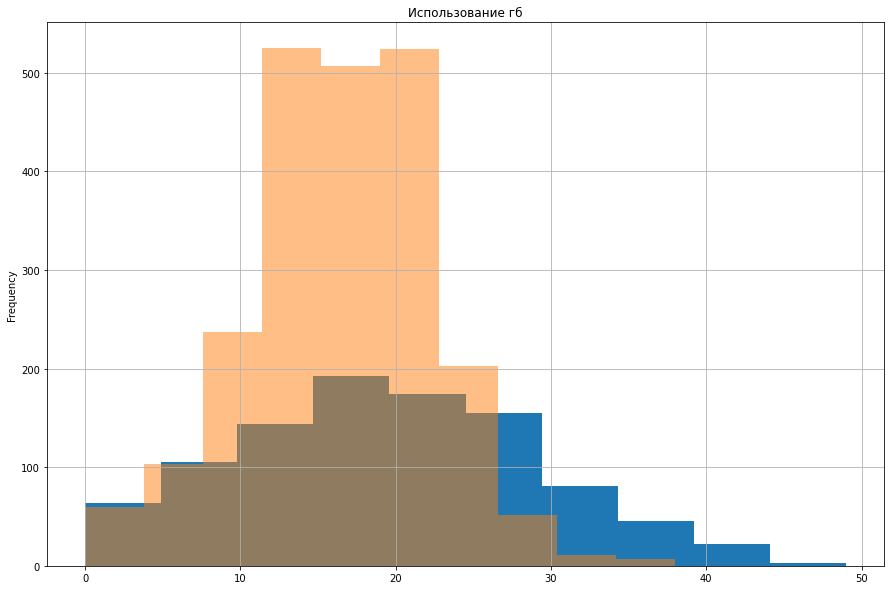

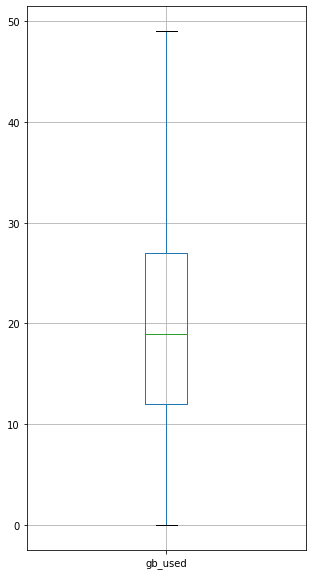

96.99311602978692


count    985.000000
mean      19.494416
std        9.853511
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64

In [53]:
general_ultra['gb_used'].plot(kind = 'hist', figsize = (15,10),grid = True, title = 'Использование гб')
general_smart['gb_used'].plot(kind = 'hist', figsize = (15,10),grid = True, title = 'Использование гб', alpha = 0.5)
plt.pyplot.show()
general_ultra.boxplot(column = 'gb_used', figsize = (5,10))
plt.pyplot.show()
print (np.var(general_ultra['gb_used']))
general_ultra['gb_used'].describe()

Значения распределены нормально, максимальное значение составляет 49 гб использованных гб в месяц, среднее - 19, медианное - 19. 

In [54]:
print (sum(general_ultra['over_minutes']>0)/len(general_ultra))
print (sum(general_ultra['over_messages']>0)/len(general_ultra))
print (sum(general_ultra['over_gb']>0)/len(general_ultra))

0.0
0.0
0.13604060913705585


12% пользователей пакета ultra не укладываются в тарифные лимиты по гб.

### Анализ размера выручки в зависимости от тарифа

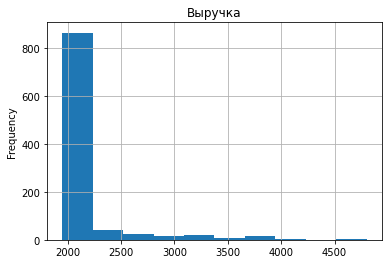

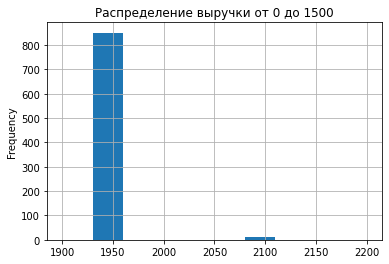

141373.07325620347


count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: total_sum, dtype: float64

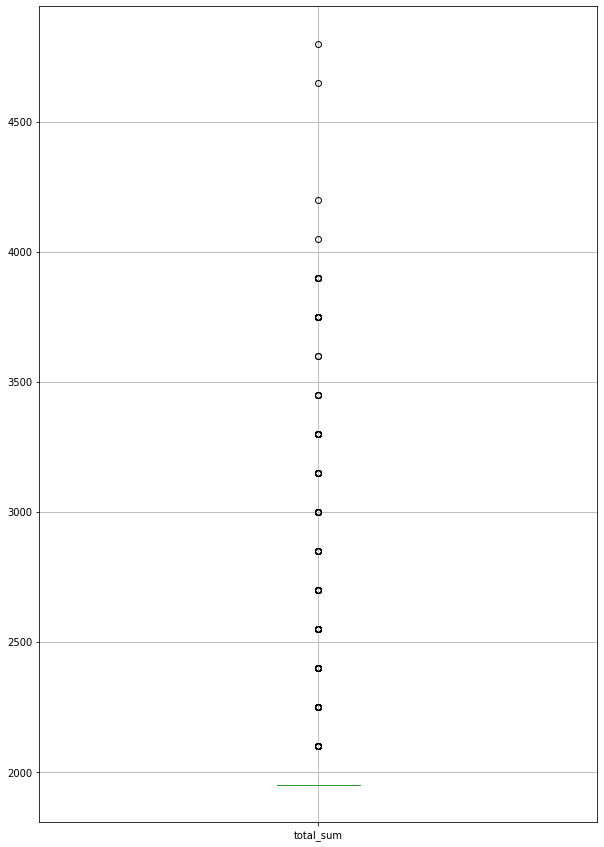

In [55]:
#Тариф ультра
general_ultra['total_sum'].plot(grid = True, kind = 'hist', title = 'Выручка')
plt.pyplot.show()
general_ultra['total_sum'].plot(grid = True, kind = 'hist', range = (1900,2200), title = 'Распределение выручки от 0 до 1500')
plt.pyplot.show()
general_ultra.boxplot(column = 'total_sum', figsize = (10,15))
print (np.var(general_ultra['total_sum']))
general_ultra['total_sum'].describe()


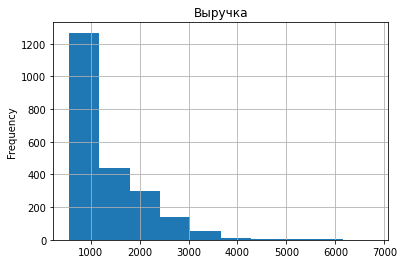

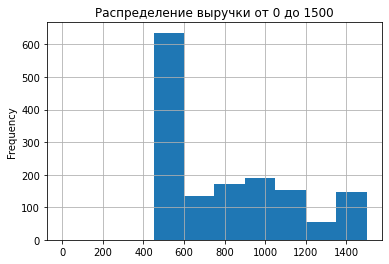

669485.2209234245


count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: total_sum, dtype: float64

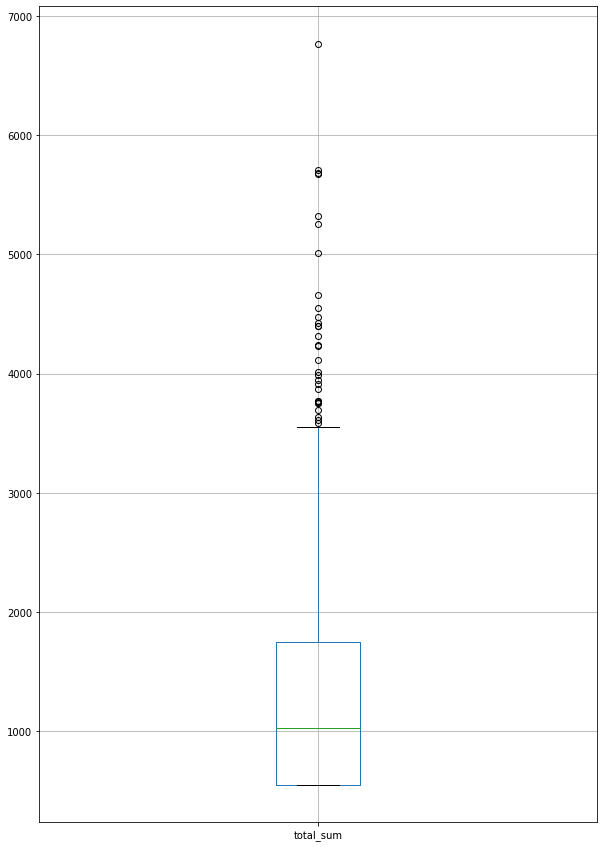

In [56]:
# Тариф Смарт
general_smart['total_sum'].plot(grid = True, kind = 'hist', title = 'Выручка')
plt.pyplot.show()
general_smart['total_sum'].plot(grid = True, kind = 'hist', range = (0,1500), title = 'Распределение выручки от 0 до 1500')
plt.pyplot.show()
general_smart.boxplot(column = 'total_sum', figsize = (10,15))
print (np.var(general_smart['total_sum']))
general_smart['total_sum'].describe()

Каждый квартиль клиентов тарифа ультра превышает размер каждого квартиля клиентов тарифа смарт. Необходимо проверить гипотезу о равенстве средних чеков тарифов.

## Изучение поведения пользователей в зависимости от географического признака

Составим отделные датафреймы для Москвичей и клиентов из других регонов. 

In [57]:
moscow_users = general_users.query('city=="Москва"')
region_users = general_users.query('city!="Москва"')

Сравним длительности разговоров

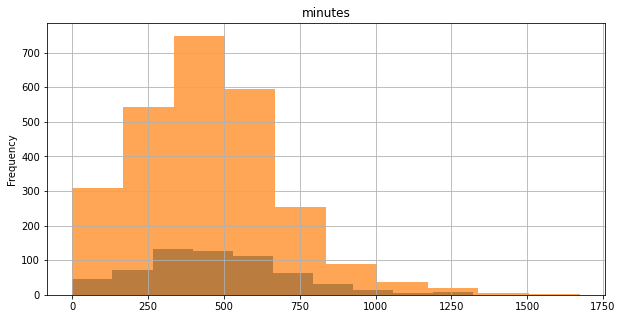

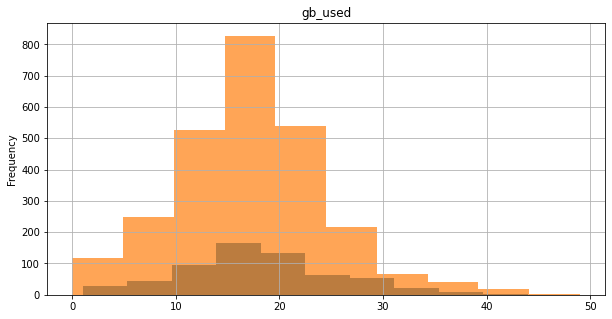

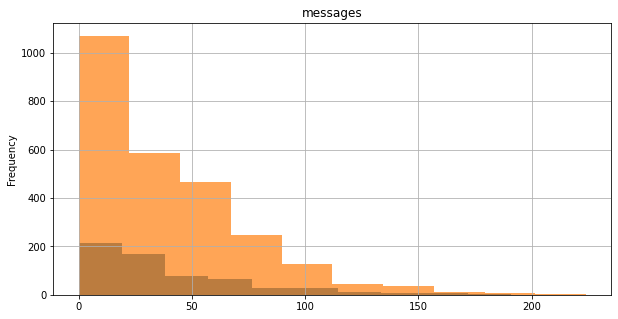

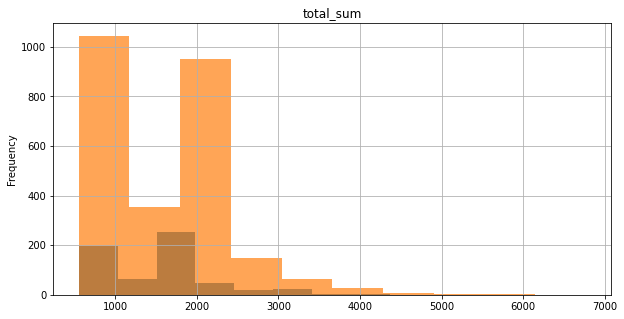

In [58]:
moscow_users['duration'].plot(kind = 'hist', figsize = (10,5), grid = True, title = 'minutes')
region_users['duration'].plot(kind = 'hist', figsize = (10,5), grid = True, title = 'minutes',alpha =0.7)
plt.pyplot.show()


moscow_users['gb_used'].plot(kind = 'hist', figsize = (10,5), grid = True, title = 'gb_used')
region_users['gb_used'].plot(kind = 'hist', figsize = (10,5), grid = True, title = 'gb_used',alpha =0.7)
plt.pyplot.show()


moscow_users['messages'].plot(kind = 'hist', figsize = (10,5), grid = True, title = 'messages')
region_users['messages'].plot(kind = 'hist', figsize = (10,5), grid = True, title = 'messages',alpha =0.7)
plt.pyplot.show()


moscow_users['total_sum'].plot(kind = 'hist', figsize = (10,5), grid = True, title = 'total_sum')
region_users['total_sum'].plot(kind = 'hist', figsize = (10,5), grid = True, title = 'total_sum',alpha =0.7)
plt.pyplot.show()



## Выводы
1. Пользователи тарифа ультра покупают тариф из-за потребности в гб(так как ни по одному из других ограничений нет превышений), при этом и те и другие пользователи чаще всего используют от 15 до 20 гб интернета. 
2. Пользователи тарифа смарт значительно чаще превышают тарифные границы и по звонкам и по смс и по использованным гб, чем пользователи тарифа ультра. 
3. Пользовательское поведение Москвичей похоже на пользовательское поведение клиентов из других регионов.

Гипотезы для проверки: 
1. Средняя выручка пользовтелей тариффа смарт отличается от средней выручки пользователей тариффа ультра. 
2. Средняя выручка пользовтелей из Москвы отличается от средней выручки пользователей из других регионов.

## Проверка гипотез

Гипотеза 1. 
Средний чек пользователей тарифа ультра отличается от среднего чека пользователей тарифа смарт. 
<p>Нулевая гипотеза: среднее двух независимых генеральных совокупностей равны, то есть средний чек обоих тарифов одинаковый.</p>
<p>Альтернативныя гипотеза: Средние чеки различаются. 
<p>Статистическую значимость возьмем за 0.01

1.4229814360764067e-160
Отвергаем нулевую гипотезу


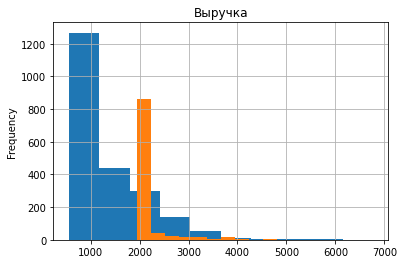

In [59]:
alpha = 0.01

results = st.ttest_ind(general_ultra['total_sum'], general_smart['total_sum'])
print(results.pvalue)
if results.pvalue<alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
general_smart['total_sum'].plot(grid = True, kind = 'hist', title = 'Выручка')
general_ultra['total_sum'].plot(grid = True, kind = 'hist', title = 'Выручка')
plt.pyplot.show()


Как, следствие, делаем вывод, что средние чеки различаются. На основании приведенных выше данных можно предположить, что средний чек пользователей тарифа "Ультра" больше, чем средний чек пользователей "Смарт". 

Гипотеза 2. 
Средний чек пользователей из Москвы отличается от среднего чека пользователей из регионов.
<p> Нулевая гипотеза: средний чек пользователей из Москвы равен среднему чеку пользователю из региона.
    <p> Альтернативная гипотеза: средний чек пользователя из Москвы отличается от среднего чека пользователя из региона
       


0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


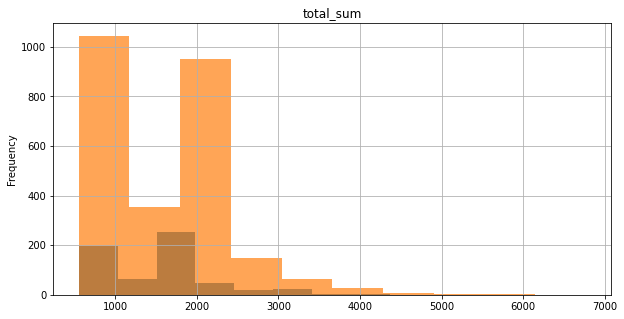

In [60]:
alpha = 0.01

results_2 = st.ttest_ind(region_users['total_sum'],moscow_users['total_sum'],equal_var = False)

print(results_2.pvalue)
if results_2.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
moscow_users['total_sum'].plot(kind = 'hist', figsize = (10,5), grid = True, title = 'total_sum')
region_users['total_sum'].plot(kind = 'hist', figsize = (10,5), grid = True, title = 'total_sum',alpha =0.7)
plt.pyplot.show()



Вероятность получить среднее значение 50 и выше! Как следствие, на основании представленных данных, нельзя отвергнуть гипотезу о том, что средний чек Москвича равен среднему чеку клиента из региона. 

# Вывод

## Описание данных

Данные были представлены в пяти различных таблицах, содержащих значения о длительности совершенных звонков, сессиях передачи данных и количестве отправленных смс по 500 клиентам компании. Также содержались значения о правилах тарификации и региональной принадлежности клиента. 
Пропусков данных практически не было, в рамках предобработки были изменены тип значений по некоторым столцам.

## Итоги исследования

На основании изученных данных можно сделать предположение, что тариф Ультра более выгоден компании, чем тариф Смарт, так как средний чек за месяц выше, при условии, что тарифы имеют одинаковую рентабельность за предоставленные минуты, смс и траффик. 
Также, можно сделать предположение, что средние чеки клиента из региона и клиента из Москвы незначительно отличаются между собой. 

<AxesSubplot:xlabel='month'>

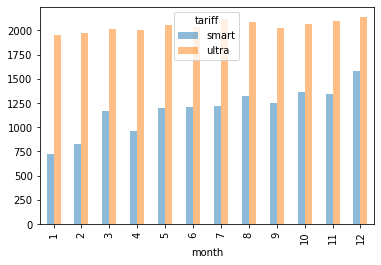

In [66]:
general_users.pivot_table(index='tariff', columns='month', values='total_sum', aggfunc='mean').T.plot(kind='bar', alpha=0.5)